In [2]:
from os import walk
import os

location = "home2"
if location == "home":
    ppipath = "/media/jim/Research_TWO/FFT_PPI"
    bpmfpath = "/home/jim/src/p39"
if location == "home2":
    ppipath = "/media/jim/fft_data/FFT_PPI"
    bpmfpath = "/home/jim/src/p39"
elif location == "ccb":
    ppipath = "/home/jtufts/FFT_PPI"
    bpmfpath = "/home/jtufts/opt/src"
elif location == "expanse":
    ppipath = "/expanse/lustre/projects/iit103/jtufts/FFT_PPI"
    bpmfpath = "/home/jtufts/src/p39"
elif location == "debug":
    ppipath = "/home/jim/src/p39/fftanalysis/test_systems"
    bpmfpath = "/home/jim/src/p39"

import re
def collect_pkl_paths(directory):
    f = []
    pattern = r'.*?\d+.*?\.pkl$'
    for root, dirs, files in os.walk(directory):
        for file in files:
            if re.match(pattern, file):
                f.append(os.path.join(root, file))
    return sorted(f)

# Collect and sort .pkl file paths
paths = collect_pkl_paths(f"{ppipath}/2.redock/6.postprocess/2OOB_A:B/")
paths = [s for s in paths if "backup" not in s.lower()]
# paths = [s for s in paths if "backup5" in s.lower()]

In [3]:
def organize_files(file_names):
    file_groups = {}

    for file_name in file_names:
        # Extract the two numbers using regular expressions
        match = re.search(r'\d+_(\d+)\.pkl$', file_name)
        if match:
            first_number = int(match.group(1))
            second_number = int(re.search(r'(\d+)_\d+\.pkl$', file_name).group(1))

            if second_number not in file_groups:
                file_groups[second_number] = {}

            if first_number not in file_groups[second_number]:
                file_groups[second_number][first_number] = []

            file_groups[second_number][first_number].append(file_name)

    return file_groups
groups = organize_files(paths)

In [30]:
def calculate_average(dictionaries):
    result = {}
    count = {}

    for dictionary in dictionaries:
        for key, value in dictionary.items():
            if key not in result:
                result[key] = 0
                count[key] = 0
            result[key] += value
            count[key] += 1

    for key in result:
        result[key] /= count[key]
    return result

In [62]:
import numpy as np
from collections import defaultdict

def calculate_exponential_average(dictionaries, temperature):
    beta = 0.001987204134799235
    kb = 0.008314
    result_a = {}
    result_b = {}
    result = {}
    count = {}
    print(result_a)

    for dictionary in dictionaries:
        for key, value in dictionary.items():
            if key not in result_a:
                result_a[key] = []
                count[key] = 0
            if key not in result_b:
                result_b[key] = []
            if key not in result:
                result[key] = 0
            delta_E = value - dictionary["OpenMM_Gas"]
            result_a[key] = result_a[key].append(-beta*(value+delta_E))  # Boltzmann constant: 0.008314 kJ/mol·K
            result_b[key] = result_b[key].append(-beta*value)
            count[key] += 1
    res_num = np.log(np.sum(np.exp(num_exponent - num_exponent.max()))) + num_exponent.max()
    res_den = np.log(np.sum(np.exp(den_exponent - den_exponent.max()))) + den_exponent.max()
    for key in result_a:
        res_num = np.log(np.sum(np.exp(result_a[key] - result_a.max()))) + result_a.max()
        res_den = np.log(np.sum(np.exp(result_b[key] - result_b.max()))) + result_b.max()
        result[key] = -kb * temperature * (res_num-res_den)

    return result


In [4]:
import numpy as np
from collections import defaultdict

def calculate_exponential_average(dictionaries, temperature):
    beta = 0.001987204134799235
    kb = 0.008314
    result_a = defaultdict(list)
    result_b = defaultdict(list)
    result = {}
    count = {}

    for dictionary in dictionaries:
        for key, value in dictionary.items():
            if key not in result_a:
                count[key] = 0
            delta_E = value - dictionary["OpenMM_Gas"]
            result_a[key].append(-beta * (value + delta_E))
            result_b[key].append(-beta * value)
            count[key] += 1

    for key in result_a:
        res_num = np.log(np.sum(np.exp(result_a[key] - np.max(result_a[key])))) + np.max(result_a[key])
        res_den = np.log(np.sum(np.exp(result_b[key] - np.max(result_b[key])))) + np.max(result_b[key])
        result[key] = -kb * temperature * (res_num - res_den)

    return result


In [5]:
import pickle
avg_bpmfs = {}
for first_number, second_numbers in groups.items():
    dict_list = []
    for second_number, files in second_numbers.items():
        # print(f"Group: First Number={first_number}, Second Number={second_number}")
        for file_name in files:
            bpmf_dict = pickle.load(open(file_name, "rb"))
            dict_list.append(bpmf_dict["bpmf"])
    avg_bpmf = calculate_exponential_average(dict_list, 300.)
    # print(first_number, avg_bpmf)
    avg_bpmfs[first_number] = avg_bpmf

In [22]:
import matplotlib.pyplot as plt

# Extract keys from the first dictionary
keys = list(avg_bpmfs[0].keys())

# Create a figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))

# Customize the appearance of the plots
colors = ['blue', 'green', 'red', 'orange', 'purple']
linestyles = ['-', '-', '-', '-', '-']

# Plot each key in a separate subplot
for i, key in enumerate(keys):
    values = [d[key] for d in avg_bpmfs]
    ax = axes[i]
    ax.plot(range(0,5001,100), values, color=colors[i], linestyle=linestyles[i], linewidth=2)
    ax.set_xlabel('Index')
    ax.set_ylabel(key)
    ax.set_title(key)
    ax.grid(True)

# Adjust spacing between subplots
plt.tight_layout()

# Save the figure if needed
# plt.savefig('plots.png')

# Show the figure
plt.show()


NameError: name 'data' is not defined

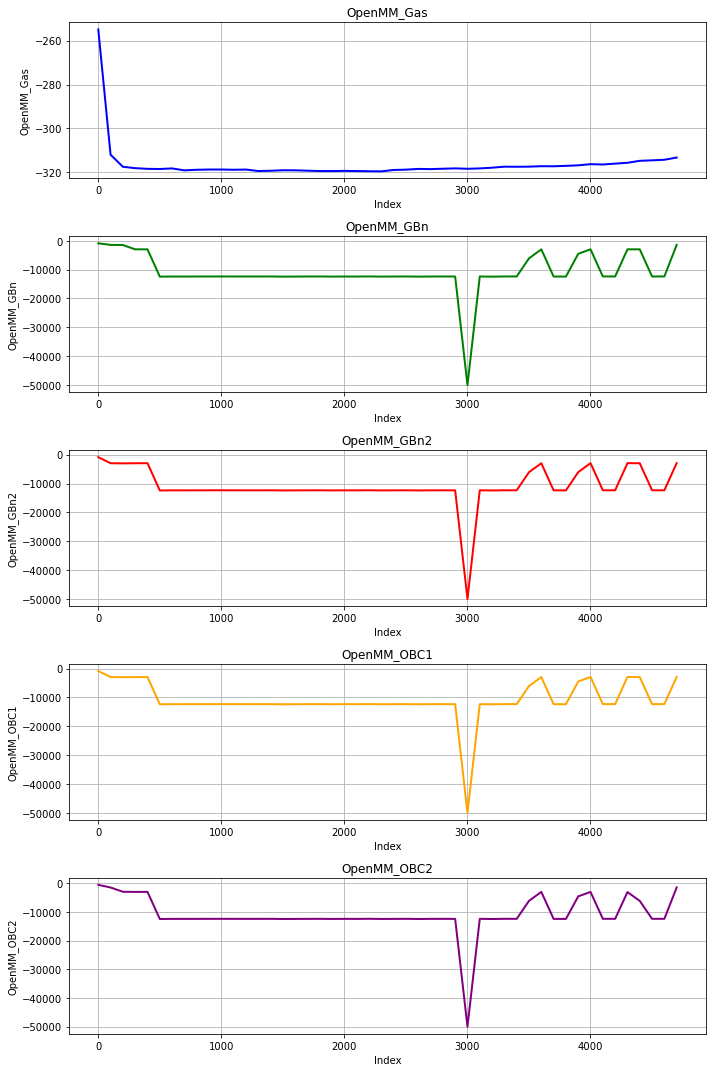

In [27]:
import matplotlib.pyplot as plt

# Extract keys from the first dictionary
keys = list(avg_bpmfs[1].keys())

# Create a figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))

# Customize the appearance of the plots
colors = ['blue', 'green', 'red', 'orange', 'purple']
linestyles = ['-', '-', '-', '-', '-']

# Plot each key in a separate subplot
for i, key in enumerate(keys):
    values = []
    for d in sorted(avg_bpmfs):
        values.append(avg_bpmfs[d][key])
    # values = [avg_bpmfs[d][key] for d in sorted(avg_bpmfs)]
    # print(key, values)
    ax = axes[i]
    # ax.plot(range(1,3500,100), sorted(values,reverse=True), color=colors[i], linestyle=linestyles[i], linewidth=2)
    ax.plot(range(1,4800,100), values, color=colors[i], linestyle=linestyles[i], linewidth=2)
    ax.set_xlabel('Index')
    ax.set_ylabel(key)
    ax.set_title(key)
    ax.grid(True)

# Adjust spacing between subplots
plt.tight_layout()

# Save the figure if needed
# plt.savefig('plots.png')

# Show the figure
plt.show()


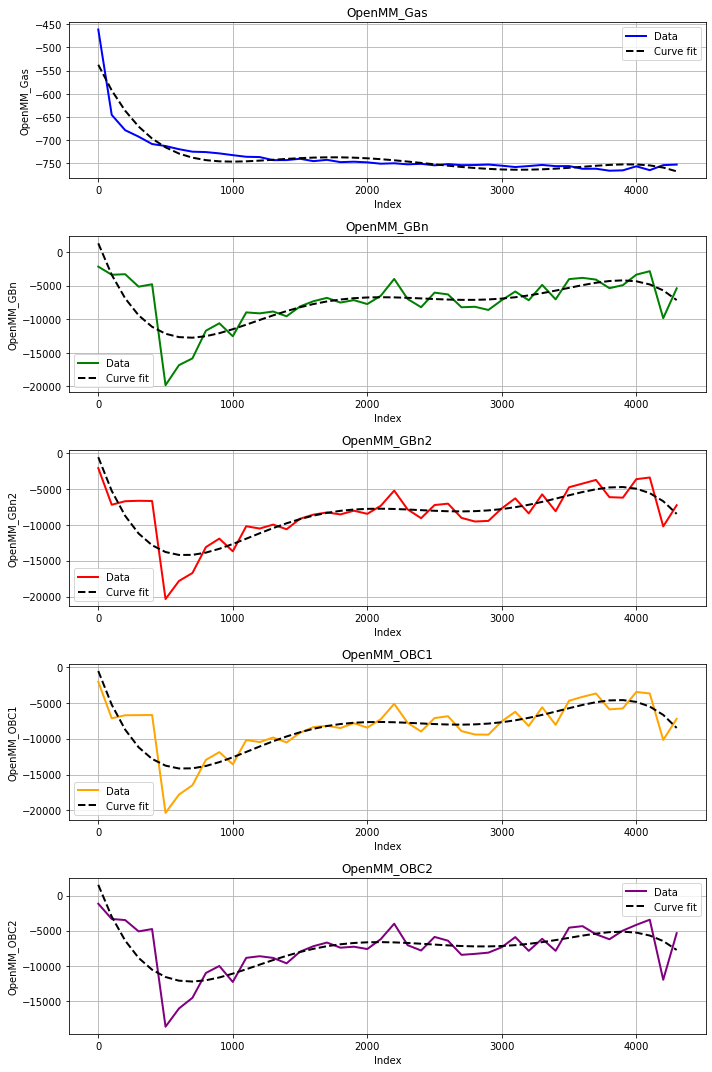

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Extract keys from the first dictionary
keys = list(avg_bpmfs[1].keys())

# Create a figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))

# Customize the appearance of the plots
colors = ['blue', 'green', 'red', 'orange', 'purple']
linestyles = ['-', '-', '-', '-', '-']

# Plot each key in a separate subplot
for i, key in enumerate(keys):
    values = []
    for d in sorted(avg_bpmfs):
        values.append(avg_bpmfs[d][key])
    
    ax = axes[i]
    x = np.arange(1, 4400, 100)
    y = np.array(values)
    
    # Plot the data points
    ax.plot(x, y, color=colors[i], linestyle=linestyles[i], linewidth=2, label='Data')
    
    # Fit a polynomial curve of degree 3
    coeffs = np.polyfit(x, y, 5)
    curve = np.poly1d(coeffs)
    
    # Plot the curve fitting line
    ax.plot(x, curve(x), color='black', linestyle='--', linewidth=2, label='Curve fit')
    
    ax.set_xlabel('Index')
    ax.set_ylabel(key)
    ax.set_title(key)
    ax.legend()  # Add a legend to the plot
    ax.grid(True)

# Adjust spacing between subplots
plt.tight_layout()

# Save the figure if needed
# plt.savefig('plots.png')

# Show the figure
plt.show()


<ipython-input-32-90d1ce61161b>:7: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
<ipython-input-32-90d1ce61161b>:7: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
<ipython-input-32-90d1ce61161b>:7: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
<ipython-input-32-90d1ce61161b>:7: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c
<ipython-input-32-90d1ce61161b>:7: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
<ipython-input-32-90d1ce61161b>:7: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c
<ipython-input-32-90d1ce61161b>:7: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


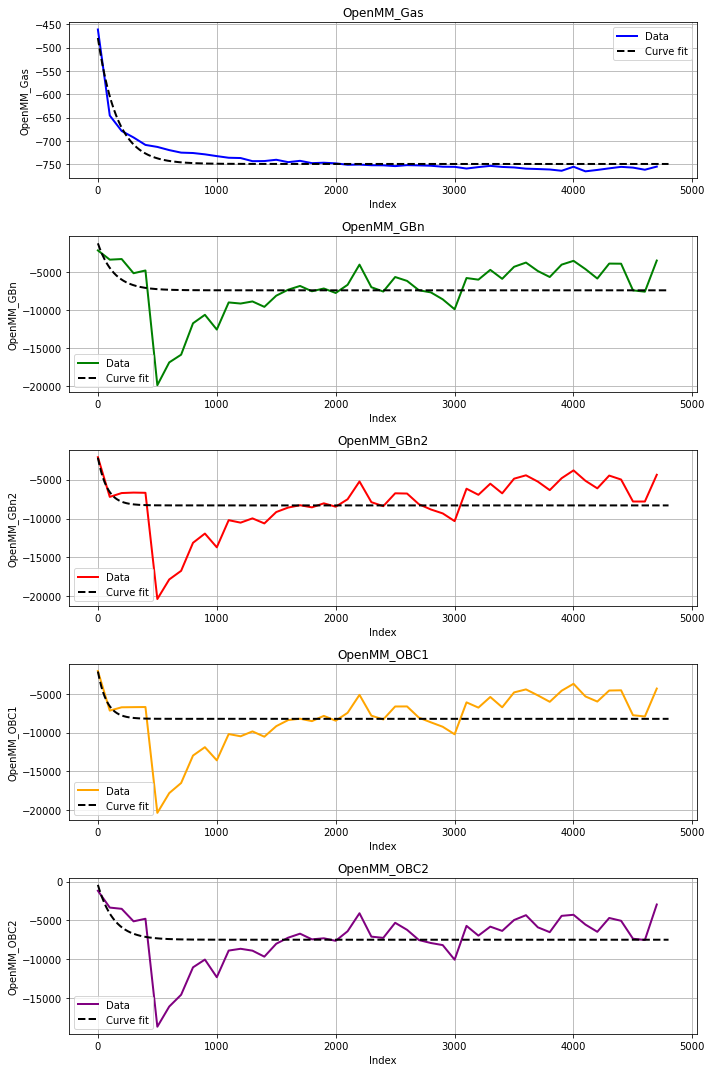

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the exponential decay function
def exponential_decay_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Extract keys from the first dictionary
keys = list(avg_bpmfs[1].keys())

# Create a figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))

# Customize the appearance of the plots
colors = ['blue', 'green', 'red', 'orange', 'purple']
linestyles = ['-', '-', '-', '-', '-']

# Plot each key in a separate subplot
for i, key in enumerate(keys):
    values = []
    for d in sorted(avg_bpmfs):
        values.append(avg_bpmfs[d][key])
    
    ax = axes[i]
    x = np.arange(1, 4800, 100)
    y = np.array(values)
    
    # Plot the data points
    ax.plot(x, y, color=colors[i], linestyle=linestyles[i], linewidth=2, label='Data')
    
    # Fit the exponential decay curve
   # Example initial guesses
    p0 = [1.0, 0.01, 1.0]

    # Fit the exponential decay curve with initial guesses
    popt, pcov = curve_fit(exponential_decay_func, x, y, p0=p0)
    
    # Generate the curve fitting line
    curve_x = np.linspace(1, 4800, 1000)
    curve_y = exponential_decay_func(curve_x, *popt)
    
    # Plot the curve fitting line
    ax.plot(curve_x, curve_y, color='black', linestyle='--', linewidth=2, label='Curve fit')
    
    ax.set_xlabel('Index')
    ax.set_ylabel(key)
    ax.set_title(key)
    ax.legend()  # Add a legend to the plot
    ax.grid(True)

# Adjust spacing between subplots
plt.tight_layout()

# Save the figure if needed
# plt.savefig('plots.png')

# Show the figure
plt.show()


ValueError: x and y must have same first dimension, but have shapes (46,) and (10,)

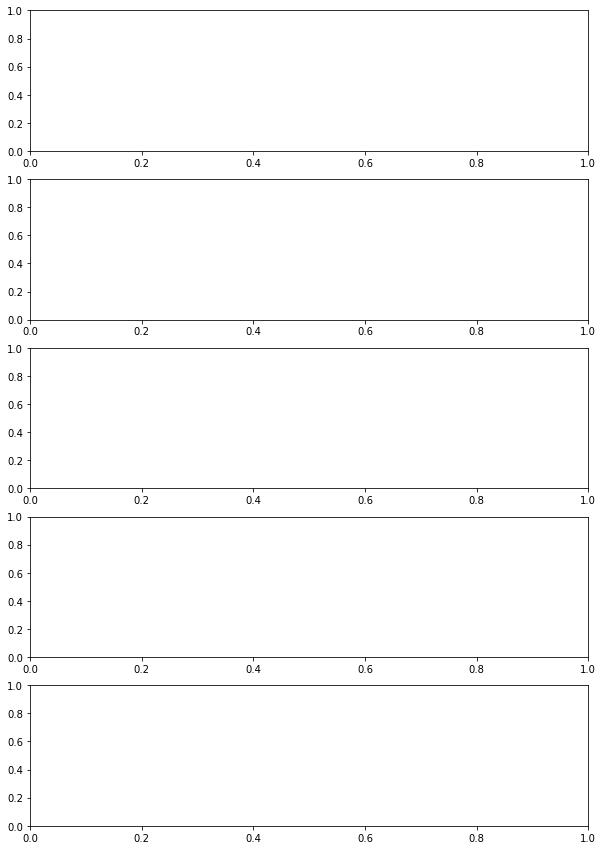

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the exponential decay function
def exponential_decay_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Extract keys from the first dictionary
keys = list(avg_bpmfs[1].keys())

# Create a figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))

# Customize the appearance of the plots
colors = ['blue', 'green', 'red', 'orange', 'purple']
linestyles = ['-', '-', '-', '-', '-']

# Plot each key in a separate subplot
for i, key in enumerate(keys):
    values = []
    for d in sorted(avg_bpmfs):
        values.append(avg_bpmfs[d][key])
    
    ax = axes[i]
    x = np.arange(1, 4600, 100)
    y = np.array(values)
    
    # Plot the data points
    ax.plot(x, y, color=colors[i], linestyle=linestyles[i], linewidth=2, label='Data')
    
    # Fit the exponential decay curve
   # Example initial guesses
    p0 = [1.0, 0.01, 1.0]

    # Fit the exponential decay curve with initial guesses
    popt, pcov = curve_fit(exponential_decay_func, x, y, p0=p0)
    
    # Generate the curve fitting line
    curve_x = np.linspace(1, 4600, 1000)
    curve_y = exponential_decay_func(curve_x, *popt)
    
    # Plot the curve fitting line
    ax.plot(curve_x, curve_y, color='black', linestyle='--', linewidth=2, label='Curve fit')
    
    ax.set_xlabel('Index')
    ax.set_ylabel(key)
    ax.set_title(key)
    ax.legend()  # Add a legend to the plot
    ax.grid(True)

# Adjust spacing between subplots
plt.tight_layout()

# Save the figure if needed
# plt.savefig('plots.png')

# Show the figure
plt.show()


/home/jim/anaconda3/envs/FFTp39/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/jim/anaconda3/envs/FFTp39/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/jim/anaconda3/envs/FFTp39/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/jim/anaconda3/envs/FFTp39/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/jim/anaconda3/envs/FFTp39/lib/python3.9/site-packages/scipy/optimize/m

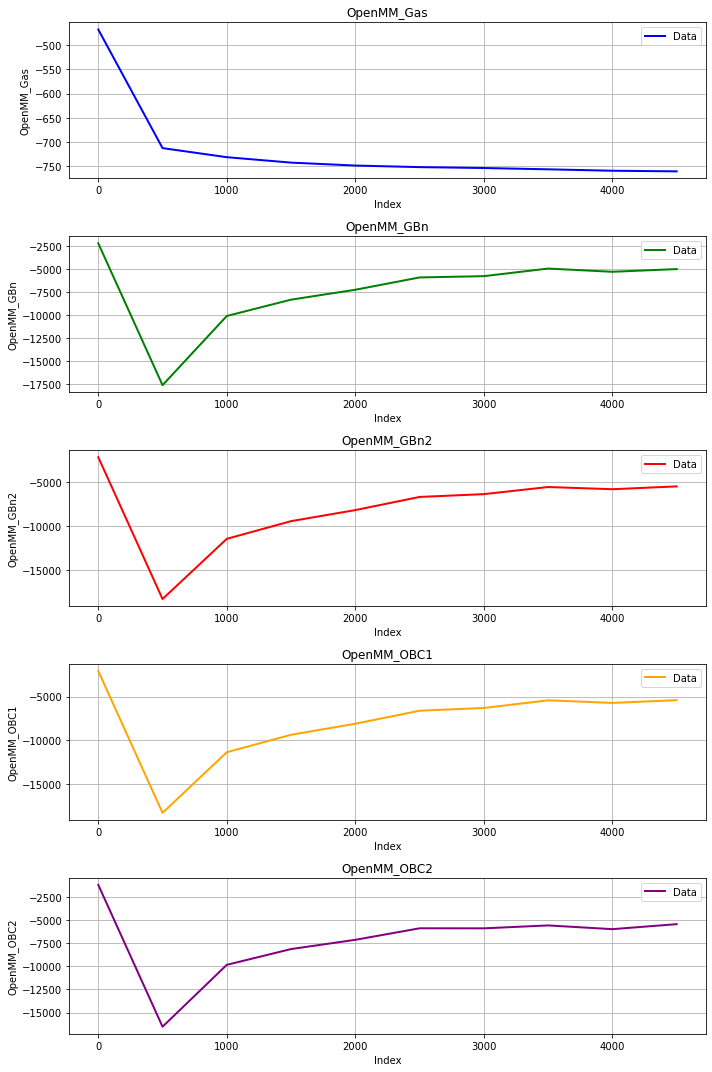

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the exponential decay function
def exponential_decay_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Extract keys from the first dictionary
keys = list(avg_bpmfs[1].keys())

# Create a figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))

# Customize the appearance of the plots
colors = ['blue', 'green', 'red', 'orange', 'purple']
linestyles = ['-', '-', '-', '-', '-']

# Plot each key in a separate subplot
for i, key in enumerate(keys):
    values = []
    for d in sorted(avg_bpmfs):
        values.append(avg_bpmfs[d][key])
    
    ax = axes[i]
    x = np.arange(1, 5000, 500)
    y = np.array(values)
    
    # Plot the data points
    ax.plot(x, y, color=colors[i], linestyle=linestyles[i], linewidth=2, label='Data')
    
    # Fit the exponential decay curve
   # Example initial guesses
    p0 = [1.0, 0.01, 1.0]

    # Fit the exponential decay curve with initial guesses
    popt, pcov = curve_fit(exponential_decay_func, x, y, p0=p0)
    
    # Generate the curve fitting line
    curve_x = np.linspace(1, 5000, 1000)
    curve_y = exponential_decay_func(curve_x, *popt)
    
    # Plot the curve fitting line
    # ax.plot(curve_x, curve_y, color='black', linestyle='--', linewidth=2, label='Curve fit')
    
    ax.set_xlabel('Index')
    ax.set_ylabel(key)
    ax.set_title(key)
    ax.legend()  # Add a legend to the plot
    ax.grid(True)

# Adjust spacing between subplots
plt.tight_layout()

# Save the figure if needed
# plt.savefig('plots.png')

# Show the figure
plt.show()


In [2]:
import pickle as p

data = []
for path in paths:
    f = p.load(open(path, "rb"))
    data.append(f['bpmf'])

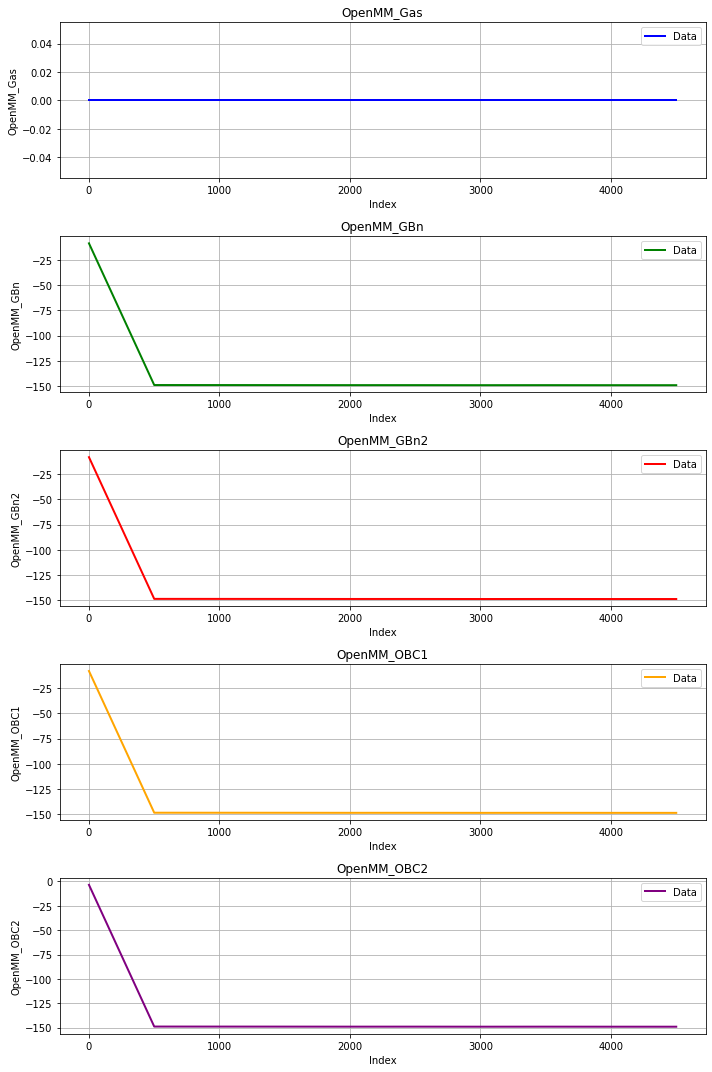

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Extract keys from the first dictionary
keys = list(avg_bpmfs[1].keys())

# Create a figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))

# Customize the appearance of the plots
colors = ['blue', 'green', 'red', 'orange', 'purple']
linestyles = ['-', '-', '-', '-', '-']

# Plot each key in a separate subplot
for i, key in enumerate(keys):
    values = []
    for d in sorted(avg_bpmfs):
        values.append(avg_bpmfs[d][key])
    
    ax = axes[i]
    x = np.arange(1, 5000, 500)
    y = np.array(values)
    
    # Plot the data points
    ax.plot(x, y, color=colors[i], linestyle=linestyles[i], linewidth=2, label='Data')
    
    # Fit a polynomial curve of degree 3
    coeffs = np.polyfit(x, y, 5)
    curve = np.poly1d(coeffs)
    
    # Plot the curve fitting line
    # ax.plot(x, curve(x), color='black', linestyle='--', linewidth=2, label='Curve fit')
    
    ax.set_xlabel('Index')
    ax.set_ylabel(key)
    ax.set_title(key)
    ax.legend()  # Add a legend to the plot
    ax.grid(True)

# Adjust spacing between subplots
plt.tight_layout()

# Save the figure if needed
# plt.savefig('plots.png')

# Show the figure
plt.savefig("dG_converge.png")
plt.show()
